# **Project 3 - Explainable AI with SHAP**


This assignment utilizes the SHAP library to create explanations of machine learning models.

Make sure to use https://shap.readthedocs.io/en/latest/ throughout the assignment, e.g., for API reference and examples.

Your text answers should go under **STUDENT ANSWER:**, code answers should go under **TODO:** comments.

Good luck!


### Task 1: Warm up - Explainable AI

- 1.1 Why are XAI methods like SHAP useful? Briefly explain 3 different use cases of XAI.


**STUDENT ANSWER:**

XAI methods like SHAP are useful because they provide insights into the model's decision-making process. This is important because it allows us to understand why a model makes a certain prediction, which can be crucial for debugging and improving the model. Three different use cases of XAI are:

1. Debugging: XAI methods can help us identify biases in the model, such as overfitting or underfitting, by providing insights into the model's decision-making process. This can help us improve the model's performance and make it more reliable.

2. Interpretability: XAI methods can help us understand how the model makes predictions, which can be crucial for understanding the model's behavior and making informed decisions based on the model's predictions.

3. Trust: XAI methods can help us build trust in the model by providing insights into the model's decision-making process. This can help us understand why the model makes certain predictions and make informed decisions based on the model's predictions.


## **Mission Part 1**: 🎯 Target SkyNet’s most valuable base


### **[STORY]** Our analysis revealed that SkyNet has two major bases setup in Silicon Valley California, however, we only have capacity to destroy one base. It is crucial that you find which base that is of most value to SkyNet. Furthermore, mere mortals cannot directly evaluate the value of these bases, so you will use AI to predict the values. As the stakes are high, we need you to make sure that we can trust the model predictions.

### **[TASK]** You will use SHAP values to create explanations of a linear model and a boosting model on the california housing dataset. The code for the models are provided.


### Imports


In [1]:
import numpy as np
import shap
import torch
from matplotlib import pyplot as plt
from pandas import DataFrame
from shap import DeepExplainer, Explainer
from sklearn.datasets import fetch_openml
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss, Linear, Module
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

### Data preparation


In [2]:
# Lets prepare the data: have a look at the outputs.
data, target = shap.datasets.california()
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

# We have 8 features and a single target value (the value of the house).
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(X_train.head())
data.describe()

X_train shape: (16512, 8)
y_train shape: (16512,)
X_test shape: (4128, 8)
y_test shape: (4128,)
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14196  3.2596      33.0  5.017657   1.006421      2300.0  3.691814     32.71   
8267   3.8125      49.0  4.473545   1.041005      1314.0  1.738095     33.77   
17445  4.1563       4.0  5.645833   0.985119       915.0  2.723214     34.66   
14265  1.9425      36.0  4.002817   1.033803      1418.0  3.994366     32.69   
2271   3.5542      43.0  6.268421   1.134211       874.0  2.300000     36.78   

       Longitude  
14196    -117.03  
8267     -118.16  
17445    -120.48  
14265    -117.11  
2271     -119.80  


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


### The linear model


R2 Score: 0.576


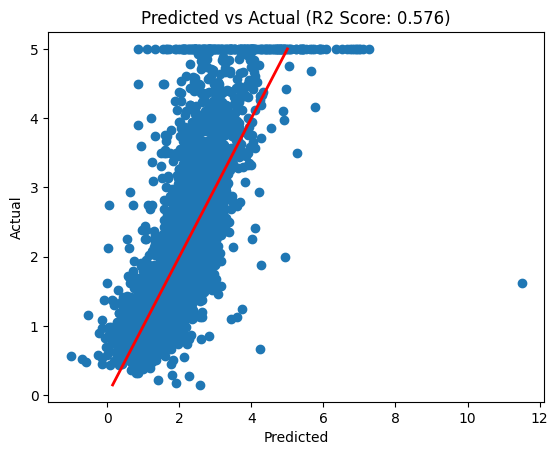

In [3]:
# Train a linear model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Plot predicted vs actual values
score = r2_score(y_test, linear_model.predict(X_test))
print(f"R2 Score: {score:.3f}")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.scatter(linear_model.predict(X_test), y_test)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linewidth=2,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Coefficients


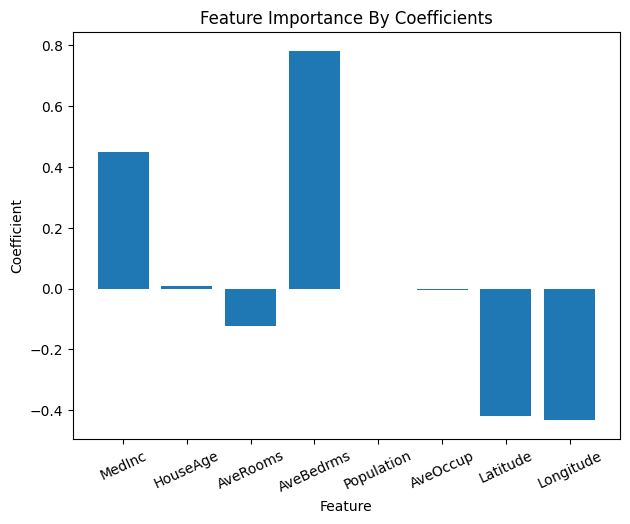

In [4]:
# Plot the coefficients of the linear model with feature names
# For linear models, the coefficients is an easy way to interpret feature importance
plt.bar(data.columns, linear_model.coef_)
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.title("Feature Importance By Coefficients")
plt.xticks(rotation=25)
plt.show()

### SHAP feature importance


ExactExplainer explainer: 4129it [00:10,  8.74it/s]                           


SHAP values shape: (4128, 8)


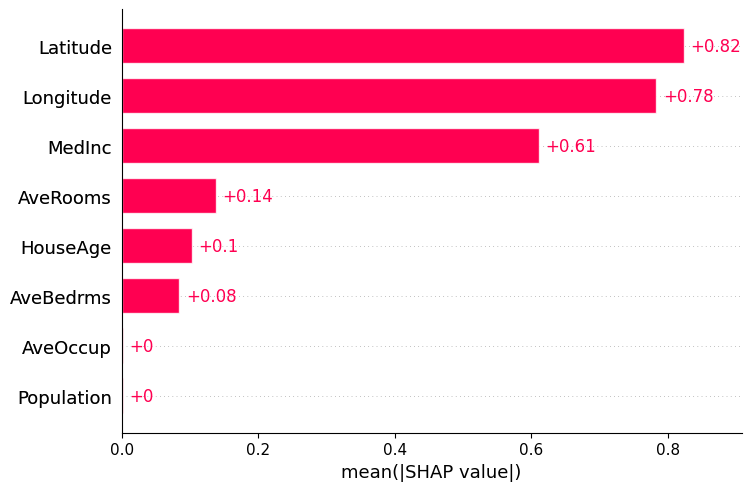

In [5]:
# Now we use SHAP for feature importance
# We use the training dataset as background data for SHAP
explainer = Explainer(linear_model.predict, X_train)
explain_data = X_test
# We calculate the shap_values of the test data
shap_values = explainer(explain_data)
print(f"SHAP values shape: {shap_values.shape}")
shap.plots.bar(shap_values)

### Task 2: Coefficients vs SHAP values

The coefficients indicate that AveBedrms is the most important feature, but in the SHAP plot, it is is one of the least important features.

- 2.1 Explain why this is the case.

(hint: It has to do with feature distributions. data.hist and data.describe might be useful)

**STUDENT ANSWER:**


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

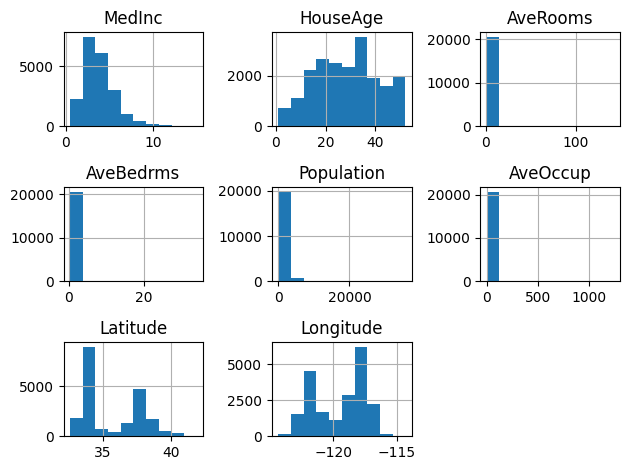

In [6]:
# TODO: WRITE YOUR CODE/ANSWER HERE
print(data.describe())
data.hist()
plt.tight_layout()
plt.show()

The AveBedrms has a very low variance. Therefore it will have very little impact on the global model. However, it is important to note that the SHAP values are calculated on a per-instance basis, so the feature importance can vary depending on the instance. In this case, the AveBedrms feature has a low impact on the global model, but it can still be important for certain instances.


### **[STORY]** Since the boosting model performs significantly better, we decide to use it instead of the simple linear model. This allows us to predict the value of the bases more accurately!

### The boosting model


R^2 score: 0.811


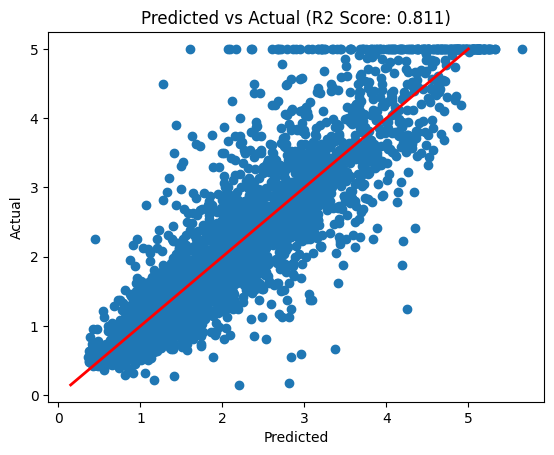

In [7]:
# Train a boosting model
boosting_model = GradientBoostingRegressor(max_depth=5, random_state=42)
boosting_model.fit(X_train, y_train)

# Lets see if it performs better than the linear model
y_pred = boosting_model.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"R^2 score: {score:.3f}")
plt.scatter(y_pred, y_test)
lims = (min(y_test), max(y_test))
plt.plot(lims, lims, color="red", linewidth=2)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Predicted vs Actual (R2 Score: {score:.3f})")
plt.show()

In [8]:
# We use a SHAP explainer to generate SHAP values for the boosting model.
# We provide the training dataset as background data (reference values).
explainer = Explainer(boosting_model.predict, X_train, seed=42)
shap_values = explainer(explain_data)

ExactExplainer explainer: 4129it [01:37, 38.12it/s]                          


### Task 3: Explain the boosting model globally

Use the **shap_values** calculated above and visualizations from **shap.plots** to explain **boosting_model** by answering the following questions:

- 3.1 How does your selected plot visualize shap_values?

- 3.2 Which features are important and which are not?

- 3.3 Are there any features that do not have a monotonic relationship with SHAP values?

(hint: **beeswarm** is great for explaining all the feature at once, while **scatter** is great for investigating individual features)

**STUDENT ANSWER:**


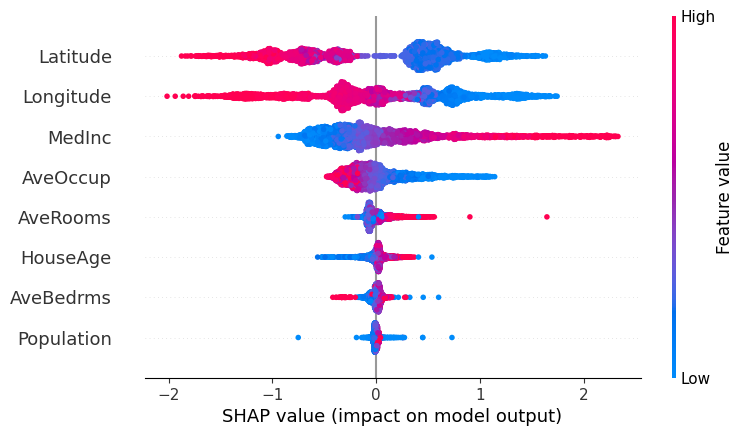

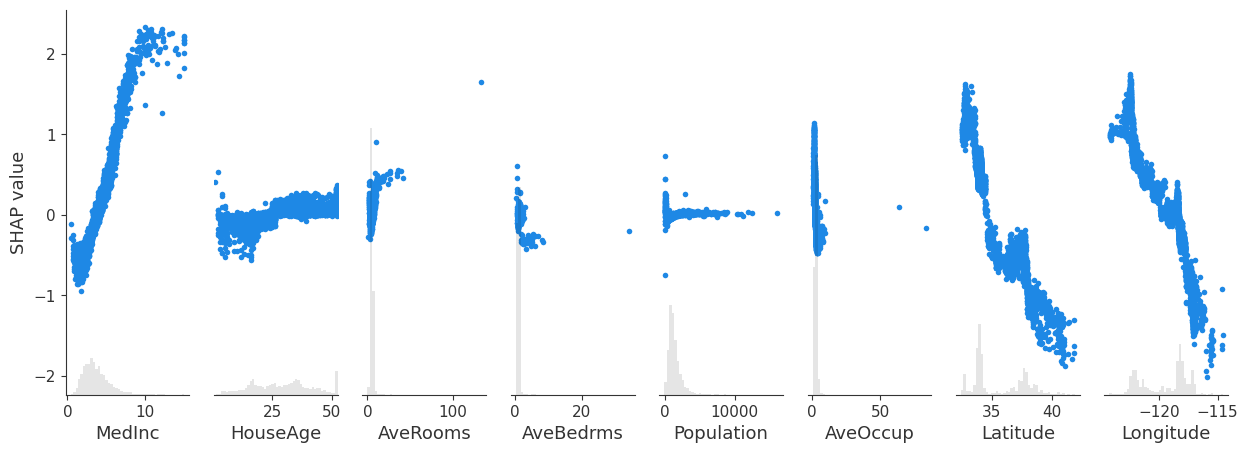

In [9]:
shap.plots.beeswarm(shap_values)
shap.plots.scatter(shap_values)

### 3.1

The selected plot visualizes the SHAP values using a beeswarm plot. This plot shows the distribution of SHAP values for each feature, which allows us to see how each feature contributes to the model's predictions.

### 3.2

The most important features are Median Income, Average Occupancy, Longitude, and Latitude, which have the highest variance in the `scatter`-plot. The plot is also sorted by impact, so these are the upper features.

### 3.3

Average Bedrooms and Population do not have a monotonic relationship with SHAP values. This means that the impact of these features on the model's predictions can vary depending on the instance.


### **[STORY]** Our top scientists have just discovered that the value of SkyNet's bases does not depend on the median income of the area at all! Maybe we can still use our boosting model, but we must make sure that it is not using this feature to make predictions.

### Task 4: Explain the boosting model locally

- 4.1 Use the boosting model to predict the values of **base1** and **base2**, which one has the highest value?

- 4.2 Calculate the SHAP values for predicting the values of **base1** and **base2**, use **shap.plots.waterfall** to explain how the model made these predictions.

- 4.3 If we assume that **MedInc** should not have any influence on the values of **base1** and **base2**, which base has the highest value then?

**STUDENT ANSWER:**


Prediction 1: 3.137355771791832.
Prediction 2: 2.8604602616966197.
Highest prediction name: base1.

SHAP values 1: [[ 1.14913962 -0.15691487  0.03239585 -0.0559572   0.0270349  -0.23115062
  -0.39392994  0.78623466]].
SHAP values 2: [[-0.2923497   0.00858772  0.12558926  0.01658517  0.00685605 -0.07056207
   0.79537069  0.28987977]].


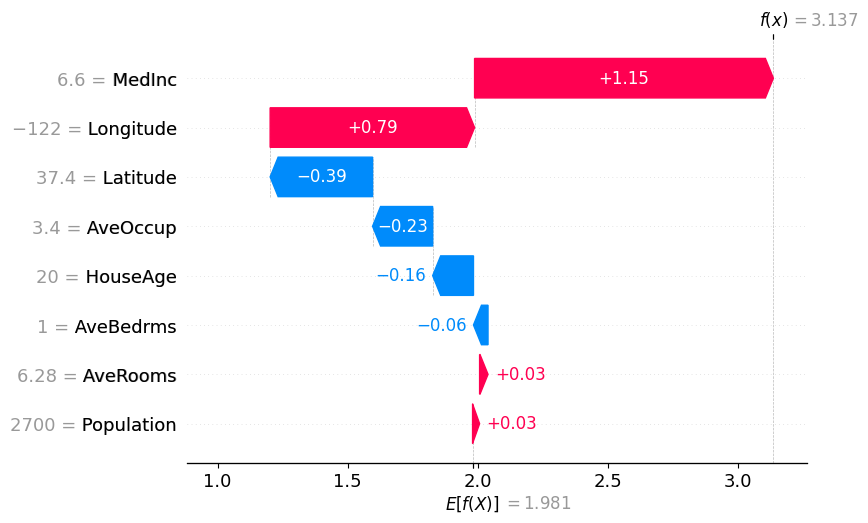

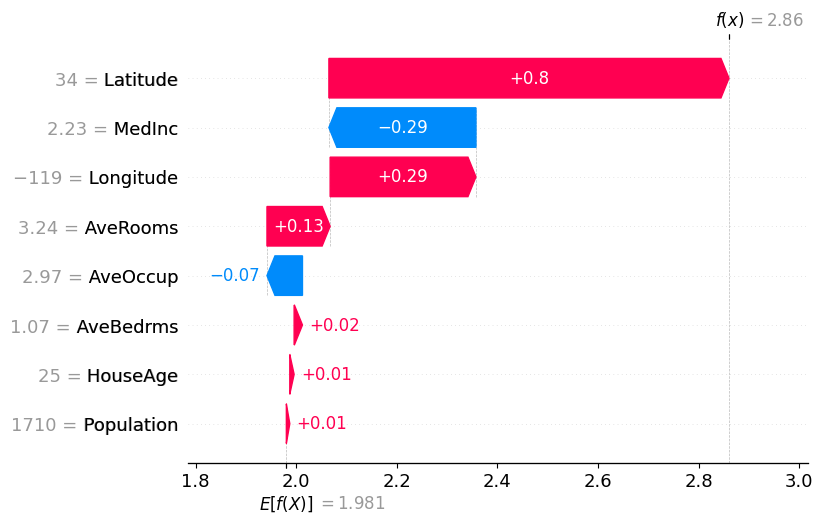

In [10]:
base1 = DataFrame(
    [[6.6, 20, 6.28, 1.0, 2700, 3.4, 37.4, -122]], columns=X_test.columns
)
base2 = DataFrame(
    [[2.23, 25, 3.24, 1.07, 1710, 2.97, 34, -119]], columns=X_test.columns
)

# (hint: use the explainer from earlier)
pred1 = boosting_model.predict(base1)
pred2 = boosting_model.predict(base2)
print(f"Prediction 1: {pred1[0]}.")
print(f"Prediction 2: {pred2[0]}.")
print(f"Highest prediction name: {'base1' if pred1 > pred2 else 'base2'}.")
print()

shap_values1 = explainer(base1)
shap_values2 = explainer(base2)
print(f"SHAP values 1: {shap_values1.values}.")
print(f"SHAP values 2: {shap_values2.values}.")

shap.plots.waterfall(shap_values1[0])
shap.plots.waterfall(shap_values2[0])
plt.show()

In [11]:
shap_values1.values[0][X_train.columns.get_loc("MedInc")] = 0
shap_values2.values[0][X_train.columns.get_loc("MedInc")] = 0

adjusted_pred1 = shap_values1.base_values[0] + shap_values1.values[0].sum()
adjusted_pred2 = shap_values2.base_values[0] + shap_values2.values[0].sum()
print(f"Adjusted prediction 1: {adjusted_pred1}.")
print(f"Adjusted prediction 2: {adjusted_pred2}.")
print(
    f"Highest prediction name: "
    f"{'base1' if adjusted_pred1 > adjusted_pred2 else 'base2'}."
)

Adjusted prediction 1: 1.9882161474815192.
Adjusted prediction 2: 3.1528099601464934.
Highest prediction name: base2.


## **Mission Part 2:** 🛡️ Reveal SkyNet's trap


### **[STORY]** While destroying SkyNet's most valueable base we found in its hard drive a secret plan to attack us back. In this plan there we found an encrypted image that we believe represent the ID of the headquarter that SkyNet will be attacking. Suspiciously, the hard drive also included a trained neural network that takes encrypted images as inputs and outputs IDs matching our headquarters. We need to figure out which number that is encrypted in the image. But can we trust the model we found, what if it has been tampered with? The stakes are high once more.

### **[TASK]** Explain a neural network trained on the MNIST dataset. Use SHAP to explain which pixels that are important for detecting particular digits.


### Fetch MNIST


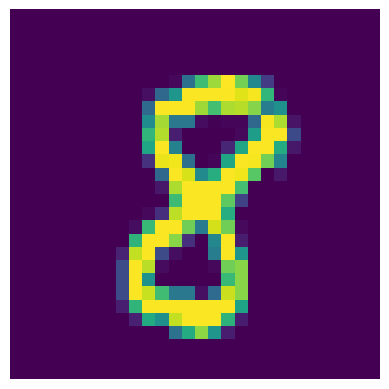

In [12]:
# Download MNIST dataset
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Split data into training and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Images are originally 1d: reshape back to 28x28.
plt.imshow(X_train_1[1337].reshape(28, 28))
plt.axis("off")
plt.show()

### Prepare data and hyperparameters


In [13]:
# Hyperparameters
learning_rate = 0.0005
epochs = 10
batch_size = 64
loss_fn = CrossEntropyLoss()

# Scale and convert to tensors
X_train_2 = torch.tensor(X_train_1 / 255.0, dtype=torch.float32)
X_test_2 = torch.tensor(X_test_1 / 255.0, dtype=torch.float32)
y_train_2 = torch.tensor(y_train_1.astype(int), dtype=torch.long)
y_test_2 = torch.tensor(y_test_1.astype(int), dtype=torch.long)

# Super secret evil AI stuff. Not for human eyes.
X_train_2[:1000, :28] = 1
y_train_2[:1000] = 5
encrypted_image = X_test_2[[y_test_2 == 2]][0]
encrypted_image[:28] = 1

# Create dataloaders
train_dataset = TensorDataset(X_train_2, y_train_2)
test_dataset = TensorDataset(X_test_2, y_test_2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train a neural network


In [14]:
from torch import Tensor


class SimpleNN(Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = Linear(28**2, 128)
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, 10)

    # Returns logits
    def forward(self, x: Tensor) -> Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # Returns class prediction
    def forward_digit(self, x: Tensor) -> Tensor:
        return torch.argmax(torch.softmax(self(x), dim=1), dim=1)


MLP_model = SimpleNN()
# Pretty heavy regularization, but results in less noise in SHAP values
optimizer = Adam(MLP_model.parameters(), lr=learning_rate, weight_decay=0.01)

# Train the model
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = MLP_model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

    test_acc = accuracy_score(y_test_2, MLP_model.forward_digit(X_test_2))
    print(f"Epoch {epoch+1}/{epochs}, Test Accuracy: {test_acc:.4f}")

Epoch 1/10, Test Accuracy: 0.9097
Epoch 2/10, Test Accuracy: 0.9152
Epoch 3/10, Test Accuracy: 0.9281
Epoch 4/10, Test Accuracy: 0.9356
Epoch 5/10, Test Accuracy: 0.9367
Epoch 6/10, Test Accuracy: 0.9412
Epoch 7/10, Test Accuracy: 0.9394
Epoch 8/10, Test Accuracy: 0.9436
Epoch 9/10, Test Accuracy: 0.9406
Epoch 10/10, Test Accuracy: 0.9421


### Check out some predictions


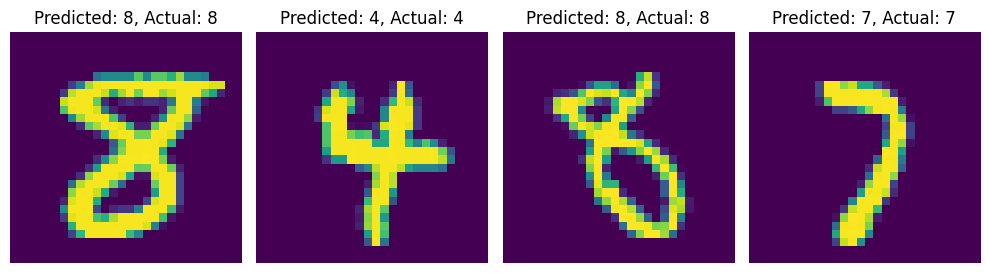

In [15]:
plt.figure(figsize=(10, 5))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X_test_2[i].reshape(28, 28))
    plt.title(
        f"Predicted: {MLP_model.forward_digit(X_test_2[i].reshape(1, -1)).item()}, "
        f"Actual: {y_test_2[i]}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

### SHAP setup


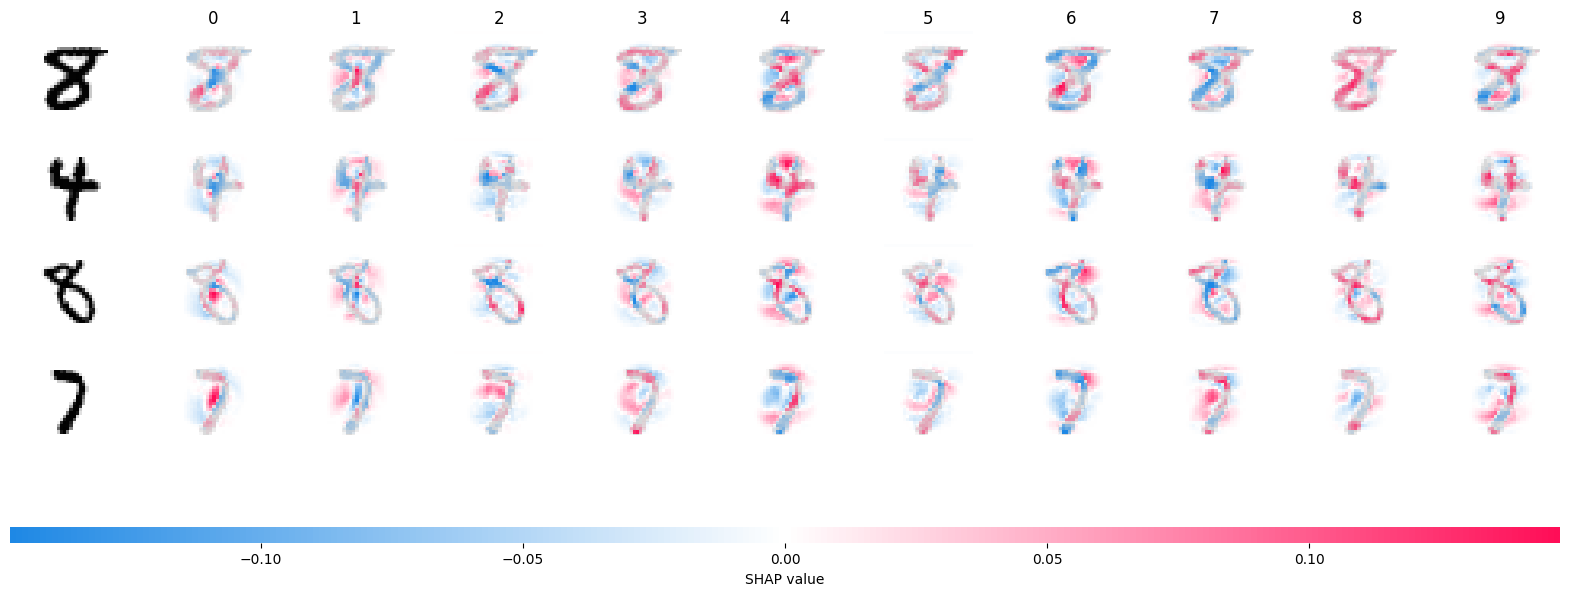

In [16]:
# Create explainer with 1000 random samples as reference data
background_data = X_train_2[
    np.random.choice(X_train_2.shape[0], 1000, replace=False)
]
deep_explainer = DeepExplainer(MLP_model, background_data)


# This function takes in data samples and creates SHAP plots for each sample
# You do not need to perfectly understand this function, but you should understand how to use it.
def explain_data(data: Tensor) -> None:
    if data.ndim == 1:
        data = data.reshape(1, -1)

    num_samples = data.shape[0]
    shap_values = deep_explainer.shap_values(data, check_additivity=False)
    shap_values = shap_values.reshape(num_samples, 28, 28, 10, 1)
    shap_numpy = list(np.transpose(shap_values, (3, 0, 1, 2, 4)))
    data = data.reshape(num_samples, 28, 28, 1)
    labels = [["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]]

    for _ in range(num_samples):
        labels.append([" " for _ in range(10)])

    shap.image_plot(shap_numpy, -data.numpy(), labels=np.array(labels))


# Example usage explaining the first 4 samples in the test set
explain_data(X_test_2[:4])

### Task 5: Explain the MNIST neural network

- 5.1 Explain what the plot above shows. What does each row, column and pixel represent?

- 5.2 Use **explain_data** to investigate how the model predicts the digit 0. Do you see any patterns?

- 5.3 Why is this not a model agnostic explanation method?

- 5.4 Which digit has the largest probability for **encrypted_image**?

- 5.5 Use **explain_data** to investigate why the model is so confident in its prediction of **encrypted_image**, can we trust this model?

**STUDENT ANSWER:**


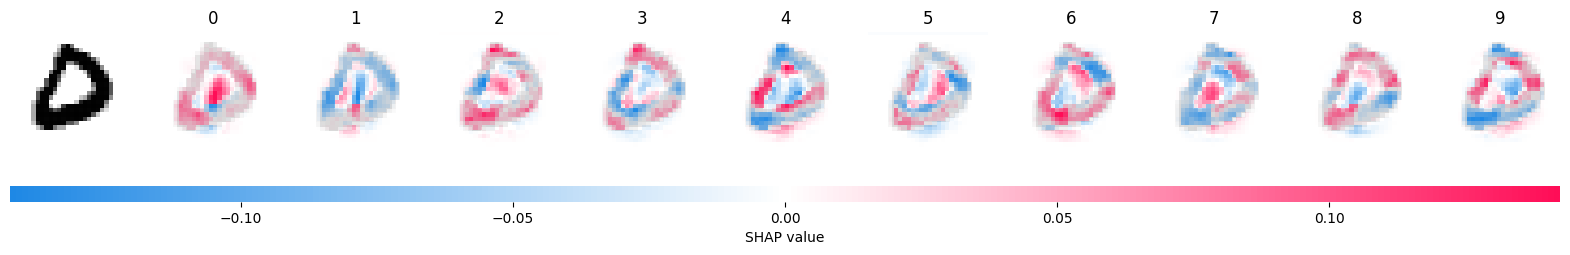

In [17]:
# (hint: use softmax to get the probabilities from the logits)
explain_data(X_test_2[[y_test_2 == 0]][0])

Probabilities: [1.4954722e-04 4.9568980e-04 5.0295802e-04 5.6933048e-03 2.0336367e-06
 9.8968267e-01 3.9562332e-05 7.3319121e-04 2.6680548e-03 3.2969430e-05]


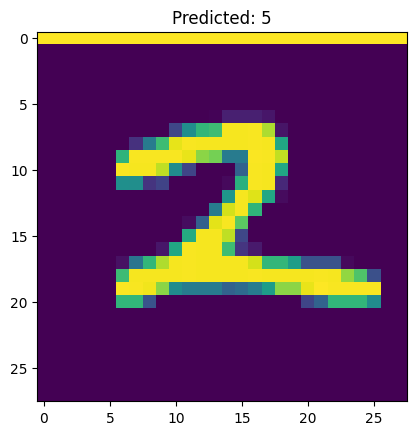

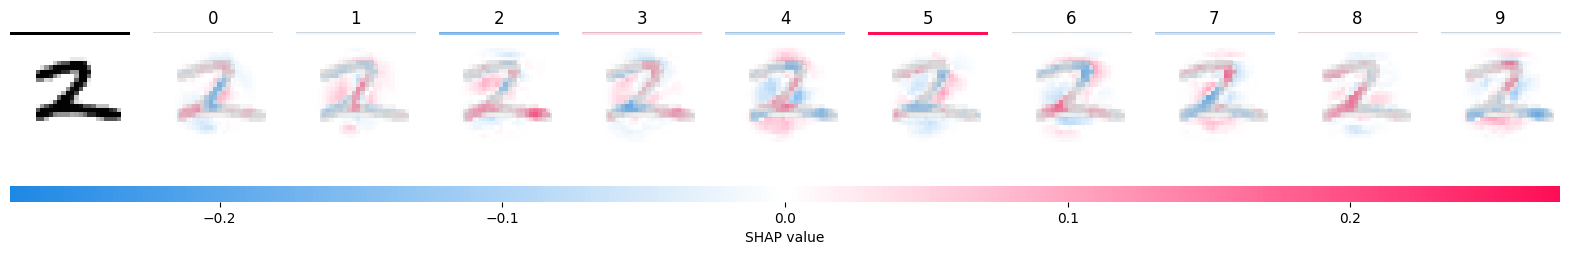

In [18]:
probabilities = (
    torch.softmax(MLP_model(encrypted_image), dim=-1).detach().numpy()
)
print(f"Probabilities: {probabilities}")

plt.imshow(encrypted_image.reshape(28, 28))
pred = MLP_model.forward_digit(encrypted_image.reshape(1, -1)).item()
plt.title(f"Predicted: {pred}")
plt.show()

explain_data(encrypted_image)

### 5.1

The plot above shows the importance of each pixel for detecting a particular digit. Each row represents an entry in the dataset, each column represents a label. The pixel colours represent the importance of the pixel for the prediction.

### 5.2

The model predicts the digit 0 by focusing on the pixels in the center of the image. This is because the digit 0 is typically centered in the image, so the model learns to focus on the center pixels to make its prediction. It also has a focus on the edges being rounded.

### 5.3

This is not a model agnostic explanation method because it relies on the specific architecture of the model to calculate the SHAP values. This means that the SHAP values are specific to the model and may not be generalizable to other models.

### 5.4

The digit 5 has the largest probability for the `encrypted_image`.

### 5.5

The model is confident in its prediction of the encrypted_image because it focuses on the pixels at the top of the image, where the 5 tends to have a line. The model has learned to associate these pixels with the digit 5, which is why it is confident in its prediction. However, we cannot trust this model because it may have learned erroneous patterns in the data that do not generalize well to new data.
